# Collaborative Filtering for Movie Recommendations

**Author:** [Siddhartha Banerjee](https://twitter.com/sidd2006)<br>
**Date created:** 2020/05/24<br>
**Last modified:** 2020/05/24<br>
**Description:** Recommending movies using a model trained on Movielens dataset.

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


## First, load the data and apply preprocessing


In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


983040/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [3]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


First, need to perform some preprocessing to encode users and movies as integer indices.


In [48]:
import itertools

In [43]:
user_ids = df["userId"].unique().tolist()
print(user_ids[:5])

[432, 288, 599, 42, 75]


In [49]:
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
#print(user2user_encoded)
dict(itertools.islice(user2user_encoded.items(), 5))

{42: 3, 75: 4, 288: 1, 432: 0, 599: 2}

In [50]:
userencoded2user = {i: x for i, x in enumerate(user_ids)}
dict(itertools.islice(userencoded2user.items(), 5))

{0: 432, 1: 288, 2: 599, 3: 42, 4: 75}

In [51]:
movie_ids = df["movieId"].unique().tolist()
movie_ids[:5]

[77866, 474, 4351, 2987, 1610]

In [52]:
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
dict(itertools.islice(movie2movie_encoded.items(), 5))

{474: 1, 1610: 4, 2987: 3, 4351: 2, 77866: 0}

In [53]:
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
dict(itertools.islice(movie_encoded2movie.items(), 5))

{0: 77866, 1: 474, 2: 4351, 3: 2987, 4: 1610}

In [54]:
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,0,0
42175,288,474,3.0,978465565,1,1
93850,599,4351,3.0,1498524542,2,2
6187,42,2987,4.0,996262677,3,3
12229,75,1610,4.0,1158989841,4,4
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,3,3936
54886,364,141,4.0,869443367,490,675
76820,480,6867,4.0,1179163171,114,2254
860,6,981,3.0,845556567,22,8229


In [55]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
print(num_users,num_movies)

610 9724


In [58]:
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## Prepare training and validation data


In [5]:
df = df.sample(frac=1, random_state=42) # trộn random
print(df.shape)
df.head()

(100836, 6)


,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727


In [6]:
x = df[["user", "movie"]].values
x

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 479, 2240],
       [   5,  712],
       [ 102, 2046]])

In [7]:
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y

array([0.88888889, 0.55555556, 0.55555556, ..., 0.77777778, 0.55555556,
       1.        ])

In [8]:
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [11]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

## Train the model based on the data split


In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6360 - val_loss: 0.6205
Epoch 2/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6130 - val_loss: 0.6173
Epoch 3/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6087 - val_loss: 0.6141
Epoch 4/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.6080 - val_loss: 0.6138
Epoch 5/5
1418/1418 [==============================] - 5s 3ms/step - loss: 0.6080 - val_loss: 0.6116


In [14]:
model.summary()

Model: "recommender_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      multiple                  30500     
_________________________________________________________________
embedding_9 (Embedding)      multiple                  610       
_________________________________________________________________
embedding_10 (Embedding)     multiple                  486200    
_________________________________________________________________
embedding_11 (Embedding)     multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


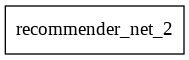

In [13]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## Plot training and validation loss


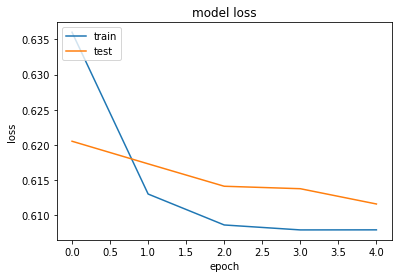

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


## Show top 10 movie recommendations to a user


In [17]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [18]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
print(user_id)

68


In [19]:
movies_watched_by_user = df[df.userId == user_id]
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
11134,68,6953,2.5,1158533556,67,2243
10538,68,1101,3.5,1158533140,67,724
10484,68,628,3.5,1158534567,67,674
10706,68,2096,3.0,1261623516,67,131
10850,68,3105,3.0,1158535471,67,2192
...,...,...,...,...,...,...
11411,68,59333,2.5,1305150692,67,906
10965,68,4054,3.5,1269123332,67,1806
11534,68,84772,4.5,1320032071,67,3480
10627,68,1617,3.5,1158531959,67,103


In [26]:
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched

3            4
7            8
8            9
11          12
12          13
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 8482, dtype: int64

In [27]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
print(len(movies_not_watched))
movies_not_watched[:5]

8464


[32770, 4, 8, 9, 12]

In [28]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
print(len(movies_not_watched))
movies_not_watched[:5]

8464


[[5804], [482], [485], [5017], [1399]]

In [29]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

67

In [31]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
print(user_movie_array.shape)
user_movie_array

(8464, 2)


array([[  67, 5804],
       [  67,  482],
       [  67,  485],
       ...,
       [  67, 3870],
       [  67, 2989],
       [  67, 7869]])

In [33]:
ratings = model.predict(user_movie_array).flatten()
print(ratings.shape)
ratings

(8464,)


array([0.5373583 , 0.4035204 , 0.44271266, ..., 0.48131263, 0.5025128 ,
       0.4417584 ], dtype=float32)

In [34]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
top_ratings_indices

array([ 553,  652,  566,  547,   88,  857,  656,  753, 1677,  856])

In [35]:
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print(len(recommended_movie_ids))
recommended_movie_ids

10


[750, 904, 778, 741, 111, 1204, 908, 1041, 2398, 1203]

In [39]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
top_movies_user

Showing recommendations for user: 68
Movies with high ratings from user
--------------------------------


array([64969,  8968, 54001, 52973,   920])

In [37]:
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
movie_df_rows

,movieId,title,genres
702,920,Gone with the Wind (1939),Drama|Romance|War
5379,8968,After the Sunset (2004),Action|Adventure|Comedy|Crime|Thriller
6481,52973,Knocked Up (2007),Comedy|Drama|Romance
6522,54001,Harry Potter and the Order of the Phoenix (2007),Adventure|Drama|Fantasy|IMAX
6929,64969,Yes Man (2008),Comedy


In [38]:
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Gone with the Wind (1939) : Drama|Romance|War
After the Sunset (2004) : Action|Adventure|Comedy|Crime|Thriller
Knocked Up (2007) : Comedy|Drama|Romance
Harry Potter and the Order of the Phoenix (2007) : Adventure|Drama|Fantasy|IMAX
Yes Man (2008) : Comedy


In [40]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
recommended_movies

--------------------------------
Top 10 movie recommendations
--------------------------------


,movieId,title,genres
98,111,Taxi Driver (1976),Crime|Drama|Thriller
596,741,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
613,778,Trainspotting (1996),Comedy|Crime|Drama
686,904,Rear Window (1954),Mystery|Thriller
690,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller
796,1041,Secrets & Lies (1996),Drama
905,1203,12 Angry Men (1957),Drama
906,1204,Lawrence of Arabia (1962),Adventure|Drama|War
1798,2398,Miracle on 34th Street (1947),Comedy|Drama


In [41]:
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Taxi Driver (1976) : Crime|Drama|Thriller
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Trainspotting (1996) : Comedy|Crime|Drama
Rear Window (1954) : Mystery|Thriller
North by Northwest (1959) : Action|Adventure|Mystery|Romance|Thriller
Secrets & Lies (1996) : Drama
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Miracle on 34th Street (1947) : Comedy|Drama
